# Encoder Decoder network


In [31]:
import torch
import torch.nn as nn
from torch.nn import init
import logging
from torchvision import models
import numpy as np
import torch.nn.functional as F

def double_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,2),stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv


def up_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(1, 18), stride=3))
    return conv
    
def up_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2,2), stride=2))
    return conv

def double_upconv1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_upconv2(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(2, 3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(2, 2), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

class encoder(nn.Module):
    def __init__(self,img_ch=2,output_ch=2):
        super(encoder, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=(2,1), stride=2)
        self.down_conv_1 = double_conv1(img_ch, 64)
        self.down_conv_2 = double_conv2(64, 128)
        self.down_conv_3 = double_conv2(128, 256)
    
    def forward(self, image):
        # encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        return x5

class decoder(nn.Module):
    def __init__(self,img_ch=2,output_ch=1):
        super(decoder, self).__init__()
        self.up_trans_1 = up_conv1(256, 128)
        self.up_conv_1 = double_upconv1(128, 64)
        
        self.up_trans_2 = up_conv2(64, 32)
        self.up_conv_2 = double_upconv2(32, 16)
        
        self.out = nn.Conv2d(
            in_channels=16,
            out_channels=output_ch,
            kernel_size=1,stride=1,padding=0)
    
    def forward(self, image):
        x = self.up_trans_1(image)
        x = self.up_conv_1(x)
        x = self.up_trans_2(x)
        x = self.up_conv_2(x)

        # output
        x = self.out(x)
        return F.softmax(x, dim=0)


In [32]:
img = torch.rand(1,2,180,4)
en = encoder()
de = decoder()

In [33]:
a = de(en(img))

In [34]:
a.size()

torch.Size([1, 1, 262, 37])

# Training 

In [35]:
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath
from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [36]:
class DOA_dataset(Dataset):
    def __init__(self, df):
        transp = np.transpose(df['SNS_data'], (2, 0, 1)) # [8, 100, 2000] => [2000, 8, 100]
        new = np.zeros((2000, 2, 8, 100))
        for i in range(0, transp.shape[0]):              # Loop to get only Real part for complex SNS_data
            for j in range(0, transp.shape[1]):
                for k in range(0, transp.shape[2]):
                    new[i][0][j][k] = transp[i][j][k].real
                    new[i][1][j][k] = transp[i][j][k].imag

        self.x = torch.from_numpy(new)
        self.y = torch.from_numpy(np.asarray(df['DOA']))
        self.n_sample = len(self.y)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_sample

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
df1 = sio.loadmat("./gdrive/MyDrive/DOA/SNR_0.mat")
dataset = DOA_dataset(df1)

validation_split = .3
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


#dataloader = DataLoader(dataset=dff, batch_size=100, shuffle=True,  num_workers=2)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=256,
                                                sampler=valid_sampler)

In [39]:
df1['SNS_data'][0][0][0]

(0.016139406547150237-0.017196661473351155j)

In [40]:

en = encoder()

pre_model = torch.load("./gdrive/MyDrive/DOA/preTrain/unet_norm.pth")
en.load_state_dict(pre_model, strict=False)

de_model = decoder()
autoencoder = nn.Sequential(en, de_model)

#==========================================================================

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	autoencoder = autoencoder.cuda()
	optimizer = optim.AdamW(autoencoder.parameters(), lr=0.001)
	criterion = criterion.cuda()

Tesla T4


In [41]:

train_loss_list = []
val_loss_list = []
epc_list = []
def train():
  for i in range(100):

    training_loss = 0
    autoencoder.train()
    for features, labels in train_loader:
      features, labels = Variable(features.cuda()), Variable(labels.cuda())
      optimizer.zero_grad()
      enn = autoencoder(features.float())
      auto_outputs = torch.transpose(enn, 2, 3) 
  
      auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 4))
      losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

      losss.backward()

      optimizer.step()
      training_loss += losss.item()

    validation_loss = 0
    correct = 0
    total = 0
    autoencoder.eval()
    with torch.no_grad():
      for features, labels in validation_loader:
        features, labels = Variable(features.cuda()), Variable(labels.cuda())

        enn = autoencoder(features.float())
        auto_outputs = torch.transpose(enn, 2, 3)
        auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 4))
        loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
        
        _, pred = torch.max(auto_outputs.data, 1)
        # print(labels[0])
        # print(pred[0])
        total+= labels.size(0)
        #print(labels)
        correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
        validation_loss += loss.item()
    train_loss = training_loss / len(train_loader)
    valid_loss = validation_loss / len(validation_loader)
    train_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)
    epc_list.append(i)
    print("Epoch {} - Traningloss: {}".format(i+1, train_loss))
    print("Validationloss: {}".format( valid_loss))
    print("Acc: {}".format( 100*correct/total))
train()

Epoch 1 - Traningloss: 5.198488062078303
Validationloss: 5.1984907786051435
Acc: 2.1666666666666665
Epoch 2 - Traningloss: 5.198226321827281
Validationloss: 5.1984931627909345
Acc: 2.1666666666666665
Epoch 3 - Traningloss: 5.197352929548784
Validationloss: 5.198484738667806
Acc: 1.5
Epoch 4 - Traningloss: 5.197402087124911
Validationloss: 5.198348840077718
Acc: 2.0
Epoch 5 - Traningloss: 5.1975228569724345
Validationloss: 5.198809623718262
Acc: 2.8333333333333335


KeyboardInterrupt: ignored

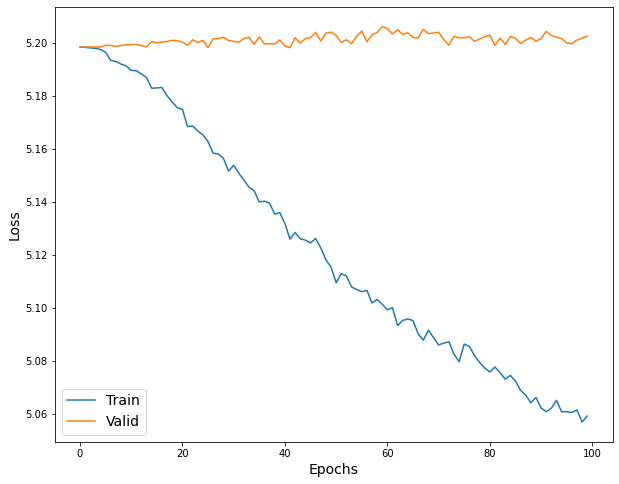

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(epc_list, train_loss_list, label='Train')
plt.plot(epc_list, val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()